In [25]:
import math
import random
import re
import pandas as pd
import matplotlib.pyplot as plt

from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution

from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm

from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.operator.crossover import PMXCrossover

from jmetal.operator import BinaryTournamentSelection
from jmetal.util.comparator import MultiComparator
from jmetal.util.ranking import StrengthRanking
from jmetal.util.density_estimator import KNearestNeighborDensityEstimator

from jmetal.util import termination_criterion
from jmetal.util.observer import ProgressBarObserver

In [26]:
class TSP(PermutationProblem):
    def __init__(self, distance_matrix, number_of_cities):
        super(TSP, self).__init__()
        self.distance_matrix = distance_matrix
        self.obj_directions = [self.MINIMIZE]
        self.number_of_variables = number_of_cities
        self.number_of_objectives = 1
        self.number_of_constraints = 0
    
    def read_from_file(filename):
        if filename is None:
            raise FileNotFoundError('Filename can not be None')
        with open(filename) as file:
            lines = file.readlines()
            data = [line.lstrip() for line in lines if line != ""]
            dimension = re.compile(r'[^\d]+')
            for item in data:
                if item.startswith('DIMENSION'):
                    dimension = int(dimension.sub('', item))
                    break
            c = [-1.0] * (2 * dimension)
            city_coord = []
            for item in data:
                if item[0].isdigit():
                    j, city_X, city_Y = [float(x.strip()) for x in item.split(' ')]
                    c[2 * (int(j) - 1)] = city_X
                    c[2 * (int(j) - 1) + 1] = city_Y
                    city_coord.append([city_X,city_Y])
            city = pd.DataFrame(city_coord)
            matrix = [[-1] * dimension for _ in range(dimension)]
            for k in range(dimension):
                matrix[k][k] = 0
                for j in range(k + 1, dimension):
                    dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                    dist = round(dist)
                    matrix[k][j] = dist
                    matrix[j][k] = dist
            return matrix, dimension, city
    
    
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        for i in range(self.number_of_variables - 1):
            x = solution.variables[i]
            y = solution.variables[i + 1]
            fitness += self.distance_matrix[x][y]
        first_city, last_city = solution.variables[0], solution.variables[-1]
        fitness += self.distance_matrix[first_city][last_city]
        solution.objectives[0] = fitness
        fitness_log.append(fitness)
        return solution
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution

    @property
    def number_of_cities(self):
        return self.number_of_variables

    def get_name(self):
        return 'Symmetric TSP'

In [27]:
def print_solution(my_algo, pop_evolved, log, params):
    algorithm_name = my_algo.get_name()
    solution_x = pop_evolved.variables
    fitness = pop_evolved.objectives[0]
    n_evals = my_algo.evaluations
    duration = my_algo.total_computing_time
    print('-' *60)
    print("Function: %s" % locality)
    print("Problem dimension: %d" % len(solution_x))
    print('-' *60)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters:")
    for p in params:
        print("\t%s: " % p ,params[p] )
    print('-' *60)
    print("Fitness: %d" % fitness)
    print("Solution: ")
    print(solution_x)
    print('-' *60)
    print("Nb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: after %d evals" % maxevals)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log[::1000])
    plt.xlabel("evaluations (x1000)")
    plt.ylabel("fitness")
    plt.show()

In [28]:
tsp =TSP
locality = 'qatar'
dist_matrix, nb_cities, cities_coord = tsp.read_from_file('./qa194.tsp')
myproblem = TSP(dist_matrix, nb_cities)

In [42]:
maxevals = 200000

popsize = 10000
offspring = 10000
mut_prob = 0.001
cross_prob = 0.3

select = BinaryTournamentSelection(
                        MultiComparator([StrengthRanking.get_comparator(),
                                         KNearestNeighborDensityEstimator.get_comparator()]
                                       ))

termin = termination_criterion.StoppingByEvaluations(max_evaluations=maxevals)

algorithm = GeneticAlgorithm(
    problem=myproblem,
    population_size=popsize,
    offspring_population_size=offspring,
    mutation=PermutationSwapMutation(mut_prob),
    crossover=PMXCrossover(cross_prob),
    selection=select,
    termination_criterion=termin
)

params = {'population':popsize, 
          'offspring':offspring, 
          'mutation probability': mut_prob, 
          'crossover probability': cross_prob,
         }


Progress: 100%|###############################################################| 200000/200000 [06:53<00:00, 484.21it/s]


------------------------------------------------------------
Function: qatar
Problem dimension: 194
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  1000
	offspring:  1000
	mutation probability:  0.05
	crossover probability:  0.9
------------------------------------------------------------
Fitness: 36443
Solution: 
[95, 90, 20, 16, 113, 129, 64, 35, 162, 163, 186, 166, 183, 175, 124, 126, 137, 140, 154, 135, 105, 68, 50, 54, 48, 32, 23, 6, 44, 53, 31, 27, 29, 30, 46, 128, 184, 190, 176, 174, 188, 146, 150, 165, 159, 65, 26, 4, 9, 8, 47, 106, 61, 85, 84, 118, 158, 161, 14, 45, 38, 42, 49, 51, 92, 120, 119, 127, 123, 122, 115, 77, 22, 88, 89, 133, 173, 180, 172, 178, 136, 108, 5, 1, 2, 40, 33, 18, 17, 13, 117, 142, 153, 139, 110, 103, 121, 131, 125, 15, 86, 28, 63, 67, 57, 66, 39, 11, 12, 10, 3, 0, 7, 62, 81, 100, 93, 97, 19, 24, 99, 171, 193, 189, 187, 179, 147, 132, 76, 43, 73, 58, 98, 109, 111, 107, 143, 157, 149, 102,

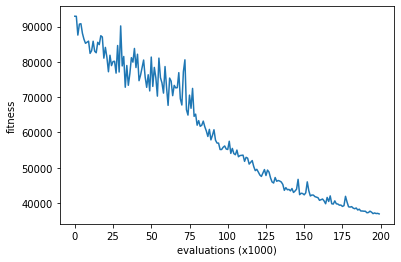

In [30]:

# run algorithm and print solution
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|###############################################################| 200000/200000 [08:05<00:00, 412.16it/s]


------------------------------------------------------------
Function: qatar
Problem dimension: 194
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  10000
	offspring:  10000
	mutation probability:  0.05
	crossover probability:  0.9
------------------------------------------------------------
Fitness: 72061
Solution: 
[131, 87, 16, 19, 62, 65, 112, 168, 89, 45, 76, 55, 105, 129, 98, 81, 107, 115, 106, 74, 77, 173, 134, 31, 42, 108, 10, 91, 75, 15, 1, 110, 53, 32, 12, 127, 152, 192, 170, 180, 154, 103, 64, 0, 165, 100, 113, 163, 36, 37, 4, 66, 6, 17, 114, 171, 143, 153, 3, 178, 133, 159, 177, 118, 186, 160, 148, 155, 187, 193, 179, 161, 121, 136, 132, 24, 67, 122, 147, 40, 20, 2, 174, 164, 182, 162, 124, 138, 167, 169, 79, 80, 14, 28, 102, 144, 83, 21, 151, 139, 84, 38, 46, 97, 190, 142, 27, 116, 47, 56, 34, 99, 50, 44, 51, 30, 39, 23, 26, 166, 71, 85, 43, 22, 49, 93, 63, 60, 72, 41, 88, 58, 35, 18, 119, 109, 94, 183, 181

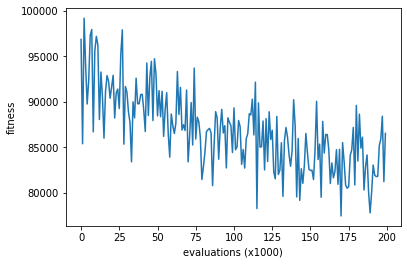

In [32]:

# run algorithm and print solution
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|###############################################################| 200000/200000 [04:44<00:00, 703.20it/s]


------------------------------------------------------------
Function: qatar
Problem dimension: 194
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  1000
	offspring:  1000
	mutation probability:  0.01
	crossover probability:  0.6
------------------------------------------------------------
Fitness: 44103
Solution: 
[24, 93, 88, 165, 184, 156, 60, 37, 16, 145, 168, 175, 111, 25, 119, 161, 74, 11, 17, 28, 128, 142, 157, 170, 162, 160, 139, 108, 113, 101, 107, 13, 23, 20, 125, 103, 138, 154, 95, 27, 3, 12, 39, 18, 4, 9, 78, 104, 169, 166, 188, 180, 174, 191, 115, 45, 49, 33, 52, 54, 38, 77, 71, 159, 179, 155, 129, 144, 153, 94, 82, 83, 72, 65, 47, 40, 43, 30, 147, 134, 109, 80, 48, 34, 87, 92, 121, 137, 148, 136, 171, 140, 164, 122, 46, 69, 36, 26, 105, 132, 127, 120, 130, 149, 124, 150, 173, 158, 135, 116, 106, 59, 102, 176, 167, 187, 186, 181, 172, 177, 192, 182, 183, 146, 64, 110, 22, 6, 29, 31, 41, 14, 7, 89, 126, 163,

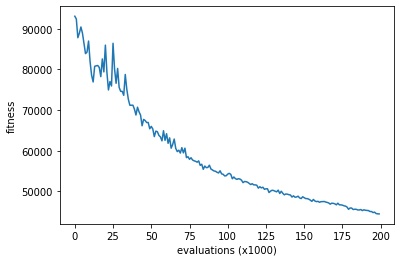

In [37]:
# run algorithm and print solution
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|###############################################################| 200000/200000 [05:52<00:00, 567.49it/s]


------------------------------------------------------------
Function: qatar
Problem dimension: 194
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  10000
	offspring:  10000
	mutation probability:  0.01
	crossover probability:  0.6
------------------------------------------------------------
Fitness: 71880
Solution: 
[117, 71, 131, 133, 148, 151, 165, 43, 51, 90, 101, 84, 140, 158, 160, 177, 127, 122, 77, 16, 170, 178, 150, 106, 187, 143, 95, 79, 27, 50, 55, 23, 53, 154, 156, 145, 58, 94, 104, 31, 68, 92, 74, 35, 59, 73, 118, 121, 179, 4, 30, 22, 144, 7, 14, 21, 138, 172, 128, 188, 173, 132, 87, 124, 44, 52, 11, 8, 2, 19, 168, 88, 129, 111, 161, 176, 120, 98, 186, 162, 113, 126, 136, 163, 100, 171, 130, 152, 190, 13, 85, 105, 6, 57, 33, 63, 75, 110, 91, 96, 17, 97, 40, 64, 62, 141, 166, 153, 15, 103, 174, 167, 180, 41, 39, 24, 146, 191, 184, 189, 149, 185, 108, 60, 181, 107, 142, 80, 192, 155, 36, 99, 67, 83, 134, 175, 

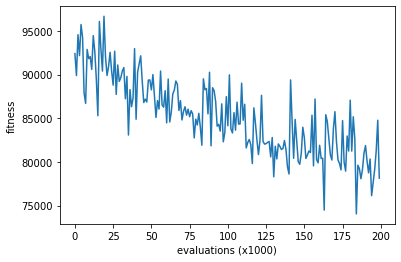

In [39]:
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|##############################################################| 200000/200000 [03:03<00:00, 1091.11it/s]


------------------------------------------------------------
Function: qatar
Problem dimension: 194
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  1000
	offspring:  1000
	mutation probability:  0.001
	crossover probability:  0.3
------------------------------------------------------------
Fitness: 53217
Solution: 
[80, 71, 77, 70, 159, 127, 102, 175, 138, 180, 83, 23, 26, 69, 160, 133, 131, 129, 96, 82, 97, 1, 3, 81, 104, 165, 167, 190, 25, 16, 112, 187, 171, 181, 186, 66, 21, 34, 76, 103, 44, 59, 12, 24, 100, 47, 54, 114, 116, 155, 118, 88, 84, 19, 85, 139, 166, 169, 154, 146, 188, 191, 143, 168, 163, 152, 162, 63, 11, 55, 31, 39, 51, 43, 49, 75, 29, 41, 28, 95, 94, 13, 42, 106, 115, 22, 38, 56, 8, 45, 52, 107, 173, 185, 189, 142, 149, 176, 158, 153, 182, 90, 27, 68, 113, 101, 61, 7, 32, 40, 99, 121, 144, 151, 124, 172, 136, 93, 98, 6, 10, 9, 33, 78, 105, 92, 30, 17, 72, 141, 145, 125, 135, 147, 161, 178, 134, 53, 11

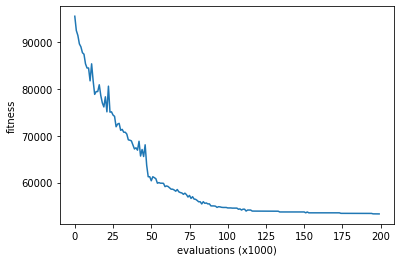

In [41]:
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|###############################################################| 200000/200000 [03:37<00:00, 920.48it/s]


------------------------------------------------------------
Function: qatar
Problem dimension: 194
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  10000
	offspring:  10000
	mutation probability:  0.001
	crossover probability:  0.3
------------------------------------------------------------
Fitness: 72704
Solution: 
[169, 36, 116, 166, 189, 40, 76, 94, 130, 133, 61, 54, 31, 86, 159, 147, 167, 138, 21, 46, 50, 117, 26, 172, 150, 173, 192, 144, 153, 135, 27, 69, 6, 62, 12, 102, 113, 126, 124, 168, 152, 154, 97, 141, 112, 18, 176, 190, 32, 108, 179, 162, 175, 191, 72, 30, 13, 51, 100, 180, 158, 182, 121, 2, 45, 187, 9, 29, 170, 193, 4, 151, 107, 67, 42, 104, 24, 129, 132, 164, 79, 75, 64, 134, 118, 185, 19, 59, 111, 16, 57, 80, 60, 7, 63, 68, 56, 156, 143, 146, 38, 120, 70, 114, 55, 47, 90, 44, 165, 184, 81, 85, 110, 148, 155, 93, 181, 82, 136, 128, 127, 20, 83, 178, 161, 188, 174, 163, 131, 160, 11, 22, 139, 157, 99, 17

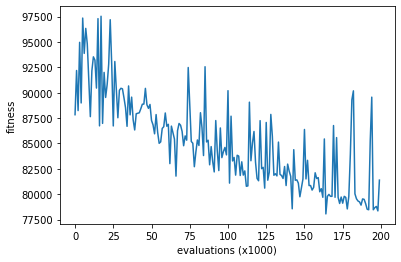

In [43]:
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)